In [1]:
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision

from L2CSNet.model import L2CS
from utils.l2csnet_util import draw_gaze, select_device
from face_detection import RetinaFace

In [2]:
def getArch(arch,bins):
    # Base network structure
    if arch == 'ResNet18':
        model = L2CS( torchvision.models.resnet.BasicBlock,[2, 2,  2, 2], bins)
    elif arch == 'ResNet34':
        model = L2CS( torchvision.models.resnet.BasicBlock,[3, 4,  6, 3], bins)
    elif arch == 'ResNet101':
        model = L2CS( torchvision.models.resnet.Bottleneck,[3, 4, 23, 3], bins)
    elif arch == 'ResNet152':
        model = L2CS( torchvision.models.resnet.Bottleneck,[3, 8, 36, 3], bins)
    else:
        if arch != 'ResNet50':
            print('Invalid value for architecture is passed! '
                'The default value of ResNet50 will be used instead!')
        model = L2CS( torchvision.models.resnet.Bottleneck, [3, 4, 6,  3], bins)
    return model

In [3]:
cudnn.enabled = True
arch='ResNet50'
batch_size = 1
gpu = select_device('0', batch_size=batch_size)
snapshot_path = '/mnt/iot-qnap3/mochida/medical-care/EmoEstimateByJAANet/code/L2CSNet/models/Gaze360/L2CSNet_gaze360.pkl'

transformations = transforms.Compose([
        transforms.Resize(448),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

In [4]:
model=getArch(arch, 90)
saved_state_dict = torch.load(snapshot_path)
model.load_state_dict(saved_state_dict)
model.cuda(gpu)
model.eval()

softmax = nn.Softmax(dim=1)
detector = RetinaFace(gpu_id=0)
idx_tensor = [idx for idx in range(90)]
idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)
x=0

pitch_predicted:-17.411468505859375, yaw_predicted:9.467880249023438


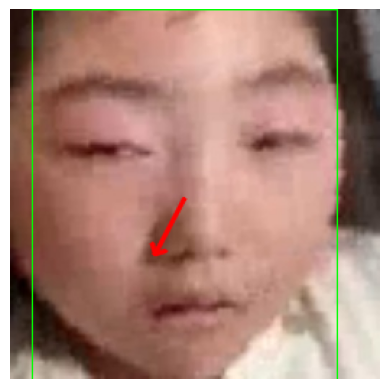

In [10]:
video_name = 'video19'
frame_num = 1503
frame_num = str(frame_num).zfill(4)
frame = cv2.imread(f'/mnt/iot-qnap3/mochida/medical-care/EmoEstimateByJAANet/data_v2/imgs/{video_name}/{video_name}_{frame_num}.jpg')
with torch.no_grad():
    faces = detector(frame)
    if faces is not None: 
        for box, landmarks, score in faces:
            if score < .95:
                continue
            x_min=int(box[0])
            if x_min < 0:
                x_min = 0
            y_min=int(box[1])
            if y_min < 0:
                y_min = 0
            x_max=int(box[2])
            y_max=int(box[3])
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min

            # Crop image
            img = frame[y_min:y_max, x_min:x_max]
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im_pil = Image.fromarray(img)
            img=transformations(im_pil)
            img  = Variable(img).cuda(gpu)
            img  = img.unsqueeze(0) 
                    
            # gaze prediction
            gaze_yaw, gaze_pitch, mid_feat = model(img)
            
            pitch_predicted = softmax(gaze_pitch)
            yaw_predicted = softmax(gaze_yaw)
            # 90次元の確率を取得
            
            # Get continuous predictions in degrees.
            pitch_predicted = torch.sum(pitch_predicted.data[0] * idx_tensor) * 4 - 180
            yaw_predicted = torch.sum(yaw_predicted.data[0] * idx_tensor) * 4 - 180
            print(f"pitch_predicted:{pitch_predicted}, yaw_predicted:{yaw_predicted}")
                    
            pitch_predicted= pitch_predicted.cpu().detach().numpy() * np.pi/180.0
            yaw_predicted= yaw_predicted.cpu().detach().numpy() * np.pi/180.0
   
            draw_gaze(x_min,y_min,bbox_width, bbox_height,frame,(yaw_predicted,pitch_predicted),color=(0,0,255))
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0,255,0), 1)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()